In [1]:
from osgeo import gdal
from matplotlib import pyplot as plt
import numpy as np
import os
from src.data_utils import data_processing as dp
from src.data_utils.data_processing import make_model_dataset
from imblearn.ensemble import EasyEnsembleClassifier
import warnings
warnings.filterwarnings("ignore")

# Read data

In [2]:
import xarray
f = xarray.open_dataset('areacella_fx_inmcm4_rcp45_r0i0p0.nc')
df = f.to_dataframe()
df

lat_bnds  lon_bnds    areacella
lat    bnds lon                                   
-89.25 0    0.0       -90.0      -1.0  485575040.0
            2.0       -90.0       1.0  485575040.0
            4.0       -90.0       3.0  485575040.0
            6.0       -90.0       5.0  485575040.0
            8.0       -90.0       7.0  485575040.0
...                     ...       ...          ...
 89.25 1    350.0      90.0     351.0  485583904.0
            352.0      90.0     353.0  485583904.0
            354.0      90.0     355.0  485583904.0
            356.0      90.0     357.0  485583904.0
            358.0      90.0     359.0  485583904.0

[43200 rows x 3 columns]

### Gather X

In [3]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

In [4]:
def metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  metrics = [acc, precision, recall, f1]
  return metrics

In [5]:
def dss(start_date, end_date, station_name, station_list, ds_for_y, delta_in_x):
    '''
    Includes several days into X. Makes dataset consisting of X from make_model_dataset(weatherstation_list.csv) and y from data_meteo_kk.csv.
    
    station_list - weatherstation_list.csv,
    ds_for_y - data_meteo_kk.csv,
    delta_in_x - number of days into X.
    '''
    a = make_model_dataset(station_name = station_name, start_date = start_date, end_date = end_date, station_list = station_list)
    a.insert(loc=0, column='day', value=a.index)
    a['day'] = a['day'].dt.dayofyear

    enc = OneHotEncoder()
    enc.fit(np.array(a.day).reshape(-1, 1))
    a.drop('day', axis=1, inplace=True)

    lis = [
        [
            np.concatenate(
                (
                    np.array(a.iloc[i-delta_in_x : i]).reshape(1, -1),
                    enc.transform(
                        np.atleast_2d(a.iloc[i-1].name.dayofyear)
                    ).toarray(),
                ),
                axis=1,
            )
        ]
        for i in range(delta_in_x, a.shape[0])
    ]
    
    X = np.array(lis).reshape(np.array(lis).shape[0], -1)

    ds_for_y['Дата'] = pd.to_datetime((ds_for_y['Дата']), format="%Y/%m/%d")
    ds_for_y = ds_for_y.loc[(ds_for_y['Дата'] >= pd.to_datetime(start_date)) & (ds_for_y['Дата'] <= pd.to_datetime(end_date))]
    ds_for_y = ds_for_y.loc[ds_for_y['Название метеостанции'] == station_name]
    ds_for_y = ds_for_y.groupby(ds_for_y['Дата']).max()   # Как группируется?
    max_speed = ds_for_y[['Максимальная скорость', 'Средняя скорость ветра']].max(axis=1)
    y = np.array((max_speed >= 20).astype(int))
    y = y[delta_in_x:a.shape[0]]

    return X, y

In [8]:
# a = make_model_dataset(station_name = 'Туапсе', start_date = start, end_date = end, station_list = st)
# a.insert(loc=0, column='day', value=a.index)
# a['day'] = a['day'].dt.dayofyear

# enc = OneHotEncoder()
# enc.fit(np.array(a.day).reshape(-1, 1))
# a.drop('day', axis=1, inplace=True)

### Add OHE

In [6]:
def make_ds(start_date, end_date, station_name, station_list, ds_for_y):
    '''
    Makes dataset consisting of X from make_model_dataset(weatherstation_list.csv) and y from data_meteo_kk.csv.
    
    station_list - weatherstation_list.csv,
    ds_for_y - data_meteo_kk.csv.
    '''
    a = make_model_dataset(station_name = station_name, start_date = start_date, end_date = end_date, station_list = station_list)
    a.insert(loc=0, column='day', value=a.index)
    a['day'] = a['day'].dt.dayofyear

    enc = OneHotEncoder()
    enc.fit(np.array(a.day).reshape(-1, 1))
    a.drop('day', axis=1, inplace=True)

    lis = [[enc.transform(np.atleast_2d(a.iloc[i].name.dayofyear)).toarray()] for i in range(a.shape[0])]
    ohe_day = pd.DataFrame(np.array(lis).reshape(np.array(lis).shape[0], -1))

    X = pd.concat([a, ohe_day.set_index(a.index)], axis=1)

    ds_for_y['Дата'] = pd.to_datetime((ds_for_y['Дата']), format="%Y/%m/%d")
    ds_for_y = ds_for_y.loc[(ds_for_y['Дата'] >= pd.to_datetime(start_date)) & (ds_for_y['Дата'] <= pd.to_datetime(end_date))]
    ds_for_y = ds_for_y.loc[ds_for_y['Название метеостанции'] == station_name]
    ds_for_y = ds_for_y.groupby(ds_for_y['Дата']).max()   # Как группируется?
    max_speed = ds_for_y[['Максимальная скорость', 'Средняя скорость ветра']].max(axis=1)
    y = np.array((max_speed >= 20).astype(int))

    return X, y

In [8]:
start = '2006-01-01'
end = '2020-01-01'
df = pd.read_csv('data_meteo_kk.csv')
st = pd.read_csv('weatherstation_list.csv')

In [19]:
st.loc[st['Индекс ВМО'] == 37107]
# Все на нижний регистр

,Индекс ВМО,Наименование станции,Широта,Долгота,Высота метеопл.,Начало наблюдений,Примечание
507,37107.0,Красная Поляна,43.683333,40.2,564.0,1914.0,NaN


In [10]:
dd = set(df['Название метеостанции'].unique())
ss = set(st['Наименование станции'].unique())
ss & dd

{'Анапа',
 'Армавир',
 'Краснодар, Круглик',
 'Приморско-Ахтарск',
 'Сочи',
 'Туапсе'}

In [27]:
X_an, y_an = make_ds(start, end, 'Анапа', st, df) #310
X_ar, y_ar = make_ds(start, end, 'Армавир', st, df) #75
X_kr, y_kr = make_ds(start, end, 'Краснодар, Круглик', st, df) #38
X_so, y_so = make_ds(start, end, 'Сочи', st, df) #28
X_tu, y_tu = make_ds(start, end, 'Туапсе', st, df) #160
X_pr, y_pr = make_ds(start, end, 'Приморско-Ахтарск', st, df) #163

In [30]:
X_an_d, y_an_d = dss(start, end, 'Анапа', st, df, 15) #310
X_ar_d, y_ar_d = dss(start, end, 'Армавир', st, df, 15) #75
X_kr_d, y_kr_d = dss(start, end, 'Краснодар, Круглик', st, df, 15) #38
X_so_d, y_so_d = dss(start, end, 'Сочи', st, df, 15) #28
X_tu_d, y_tu_d = dss(start, end, 'Туапсе', st, df, 15) #160
X_pr_d, y_pr_d = dss(start, end, 'Приморско-Ахтарск', st, df, 15) #163

In [56]:
clf_xgb.fit(X_tu, y_tu)
print('On test:', metrics(clf_xgb, X_an, y_an))
print('On train:', metrics(clf_xgb, X_tu, y_tu))

On test: [0.9391865467344545, 0.4, 0.0064516129032258064, 0.012698412698412697]
On train: [0.9779037935080173, 1.0, 0.29375, 0.45410628019323673]


In [57]:
clf_xgb.fit(X_an, y_an)
print('On test:', metrics(clf_xgb, X_tu, y_tu))
print('On train:', metrics(clf_xgb, X_an, y_an))

On test: [0.9649980445834963, 0.047619047619047616, 0.00625, 0.011049723756906079]
On train: [0.9581540868204927, 0.9897959183673469, 0.31290322580645163, 0.47549019607843146]


In [62]:
easy_ens = EasyEnsembleClassifier()
easy_ens.fit(X_tu, y_tu)
print('On test:', metrics(easy_ens, X_an, y_an))
print('On train:', metrics(easy_ens, X_tu, y_tu))
# Precision is decreased, recall is raised

On test: [0.5827141181071568, 0.09538598047914817, 0.6935483870967742, 0.16770670826833076]
On train: [0.6462651544779038, 0.07955124936257012, 0.975, 0.1471004243281471]


15 Days in X - overfitting

In [58]:
clf_xgb.fit(X_tu_d, y_tu_d)
print('On test:', metrics(clf_xgb, X_an_d, y_an_d))
print('On train:', metrics(clf_xgb, X_tu_d, y_tu_d))

On test: [0.9386154147872132, 0.2, 0.0032258064516129032, 0.006349206349206348]
On train: [1.0, 1.0, 1.0, 1.0]


In [59]:
clf_xgb.fit(X_an_d, y_an_d)
print('On test:', metrics(clf_xgb, X_tu_d, y_tu_d))
print('On train:', metrics(clf_xgb, X_an_d, y_an_d))

On test: [0.9680329476367915, 0.4, 0.0375, 0.06857142857142857]
On train: [1.0, 1.0, 1.0, 1.0]


Concatenate several cities

In [45]:
new_X = pd.concat([X_tu, X_pr], axis=0)
new_y = np.concatenate((y_tu, y_pr))
clf_xgb.fit(new_X, new_y)
print('On test:', metrics(clf_xgb, X_an, y_an))
print('On train:', metrics(clf_xgb, new_X, new_y))

On test: [0.9395776300351975, 0.6666666666666666, 0.0064516129032258064, 0.012779552715654953]
On train: [0.971353148220571, 1.0, 0.09287925696594428, 0.16997167138810199]


In [47]:
new_X_d = np.concatenate([X_tu_d, X_pr_d], axis=0)
new_y_d = np.concatenate((y_tu_d, y_pr_d))
clf_xgb.fit(new_X_d, new_y_d)
print('On test:', metrics(clf_xgb, X_an_d, y_an_d))
print('On train:', metrics(clf_xgb, new_X_d, new_y_d))
# Using 15 days in X causes overfitting

On test: [0.9384192979015493, 0.16666666666666666, 0.0032258064516129032, 0.006329113924050633]
On train: [1.0, 1.0, 1.0, 1.0]


In [51]:
new_X = pd.concat([X_tu, X_pr, X_ar], axis=0)
new_y = np.concatenate((y_tu, y_pr, y_ar))
clf_xgb.fit(new_X, new_y)
print('On test:', metrics(clf_xgb, X_an, y_an))
print('On train:', metrics(clf_xgb, new_X, new_y))
# Adding cities with small number of positives confuses the model

c:\Users\Артём\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On test: [0.939382088384826, 0.0, 0.0, 0.0]
On train: [0.9754269326033111, 1.0, 0.052763819095477386, 0.10023866348448687]


In [50]:
new_X = pd.concat([X_tu, X_pr, X_ar, X_kr], axis=0)
new_y = np.concatenate((y_tu, y_pr, y_ar, y_kr))
clf_xgb.fit(new_X, new_y)
print('On test:', metrics(clf_xgb, X_an, y_an))
print('On train:', metrics(clf_xgb, new_X, new_y))

On test: [0.939382088384826, 0.0, 0.0, 0.0]
On train: [0.9796147829487681, 1.0, 0.04357798165137615, 0.08351648351648353]


c:\Users\Артём\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


EasyEnsembleClassifier

In [63]:
easy_ens = EasyEnsembleClassifier()
new_X = pd.concat([X_tu, X_pr], axis=0)
new_y = np.concatenate((y_tu, y_pr))
easy_ens.fit(new_X, new_y)
print('On test:', metrics(easy_ens, X_an, y_an))
print('On train:', metrics(easy_ens, new_X, new_y))
# Precision is decreased, recall is raised

On test: [0.5887759092686742, 0.09959803483698079, 0.7193548387096774, 0.17497057669674382]
On train: [0.6607352366053969, 0.07090264521407144, 0.804953560371517, 0.13032581453634084]


### Vary Days in X
If you restart and run all, all outputs will be invalid till *The optimal number of days*

1 Day

In [136]:
clf_xgb = xgb.XGBClassifier(n_jobs=-1, random_state=1)
clf_xgb.fit(X_tu, y_tu)
metrics(clf_xgb, X_an, y_an)

[0.9391865467344545, 0.4, 0.0064516129032258064, 0.012698412698412697]

2 Days

In [ ]:
clf_xgb = xgb.XGBClassifier(n_jobs=-1, random_state=1)
clf_xgb.fit(X_tu, y_tu)
metrics(clf_xgb, X_an, y_an)

3 Days

In [69]:
clf_xgb = xgb.XGBClassifier(n_jobs=-1, random_state=1)
clf_xgb.fit(X_tu, y_tu)
metrics(clf_xgb, X_an, y_an)

[0.937976912541577,
 0.1111111111111111,
 0.0032258064516129032,
 0.006269592476489029]

4 Days

In [71]:
clf_xgb = xgb.XGBClassifier(n_jobs=-1, random_state=1)
clf_xgb.fit(X_tu, y_tu)
metrics(clf_xgb, X_an, y_an)

[0.9385518590998043, 0.0, 0.0, 0.0]

5 Days

In [51]:
clf_xgb = xgb.XGBClassifier(n_jobs=-1, random_state=1)
clf_xgb.fit(X_tu, y_tu)
metrics(clf_xgb, X_an, y_an)

[0.9387355646897632, 0.2, 0.0032258064516129032, 0.006349206349206348]

The optimal number of days

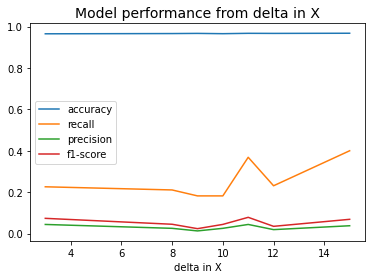

In [76]:
del_in_x = [3, 8, 9, 10, 11, 12, 15, 16]
clf_xgb = xgb.XGBClassifier(n_jobs=-1, random_state=1)
dic = {}
for d in del_in_x:
    X_train, y_train = dss(start, end, 'Анапа', st, df, d)
    X_test, y_test = dss(start, end, 'Туапсе', st, df, d) #160
    clf_xgb.fit(X_train, y_train)
    dic[d] = metrics(clf_xgb, X_test, y_test)
ac_temp, pr_temp, re_temp, f_temp = [], [], [], []
for h in del_in_x:
    ac_temp.append(dic[h][0])
    pr_temp.append(dic[h][1])
    re_temp.append(dic[h][2])
    f_temp.append(dic[h][3])

fig, ax = plt.subplots()
plt.title('Model performance from delta in X', fontsize=14)
ax.plot(del_in_x,ac_temp, label='accuracy')
ax.plot(del_in_x,pr_temp, label='recall')
ax.plot(del_in_x,re_temp, label='precision')
ax.plot(del_in_x,f_temp, label='f1-score')
plt.xlabel('delta in X')
plt.legend()
plt.show()

In [134]:
# Maybe delete el?
Xs = [X_an, X_ar, X_kr, X_so, X_tu, X_pr]
for i in Xs:
    print(i['el'][0])

2
1
-1
1
1
-3


### Road to make_ds()
Not Relevant!!!

In [95]:
start = '2006-01-01'
end = '2020-01-01'
a = make_model_dataset(station_name = 'Туапсе', start_date = start, end_date = end, station_list = st)
a.insert(loc=0, column='day', value=a.index)
a['day'] = a['day'].dt.dayofyear

enc = OneHotEncoder()
enc.fit(np.array(a.day).reshape(-1, 1))
a.drop('day', axis=1, inplace=True)
a

,tasmax,tasmin,pr,el
Date,,,,
2006-01-01,-7.827826,-16.242804,0.000031,1
2006-01-02,-8.439062,-18.564719,0.000017,1
2006-01-03,-6.218634,-10.958533,0.000054,1
2006-01-04,-6.579840,-12.962500,0.000127,1
2006-01-05,-8.012976,-16.020453,0.000059,1
...,...,...,...,...
2019-12-28,-10.246649,-17.065436,0.000017,1
2019-12-29,-11.044684,-15.441351,0.000040,1
2019-12-30,-11.974280,-18.038931,0.000012,1


In [96]:
lis = [[enc.transform(np.atleast_2d(a.iloc[i].name.dayofyear)).toarray()] for i in range(a.shape[0])]
ohe_day = pd.DataFrame(np.array(lis).reshape(np.array(lis).shape[0], -1))
ohe_day

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [97]:
X = pd.concat([a, ohe_day.set_index(a.index)], axis=1)
X

,tasmax,tasmin,pr,el,0,1,2,3,4,5,...,356,357,358,359,360,361,362,363,364,365
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,-7.827826,-16.242804,0.000031,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-02,-8.439062,-18.564719,0.000017,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-03,-6.218634,-10.958533,0.000054,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-04,-6.579840,-12.962500,0.000127,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-05,-8.012976,-16.020453,0.000059,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,-10.246649,-17.065436,0.000017,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2019-12-29,-11.044684,-15.441351,0.000040,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-12-30,-11.974280,-18.038931,0.000012,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [90]:
df = pd.read_csv('data_meteo_kk.csv')
df['Дата'] = pd.to_datetime((df['Дата']), format="%Y/%m/%d")
df = df.loc[(df['Дата'] >= pd.to_datetime(start)) & (df['Дата'] <= pd.to_datetime(end))]
df = df.loc[df['Название метеостанции'] == 'Туапсе']
df = df.groupby(df['Дата']).max()   # Как группируется?
max_speed = df[['Максимальная скорость', 'Средняя скорость ветра']].max(axis=1)
# max_speed = (max_speed >= 20).astype(int).reset_index()
y = np.array((max_speed >= 20).astype(int))
y

0       0
1       0
2       0
3       0
4       0
       ..
5109    0
5110    0
5111    0
5112    0
5113    0
Name: 0, Length: 5114, dtype: int32